In [1]:
import cobra
from cobra.sampling import sample
from cobra.sampling import OptGPSampler
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import pfba
from cobra.flux_analysis import moma
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.patches import Patch
from matplotlib import colors as mcolors
from matplotlib import font_manager
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
from psamm.datasource import native
from psamm.fluxanalysis import FluxBalanceProblem, FluxBalanceError
from psamm.lpsolver import cplex, lp
import seaborn as sns
import os
# Built-in multiprocessing pool module does not work interactively
# Run pip install pathos to use this one
from pathos.multiprocessing import ProcessingPool as Pool 
from functools import partial
from cameo import fba
from collections import defaultdict
from cameo import phenotypic_phase_plane
import pickle
import subprocess
from sklearn.model_selection import ParameterGrid
import matplotlib.ticker as mticker
import lzma

# Simulations for generating all figures for Tanwee et al. 2023

Tanwee, Tania N. N., Gina L. Lipscomb, Jason L. Vailionis, Ke Zhang, Ryan G. Bing, Hailey C. O’Quinn, Farris L. Poole, Ying Zhang, Robert M. Kelly, and Michael W. W. Adams. 2023. “Metabolic Engineering of Caldicellulosiruptor Bescii for 2,3-Butanediol Production from Unpretreated Lignocellulosic Biomass and Metabolic Strategies for Improving Yields and Titers.” Applied and Environmental Microbiology, December, e0195123.
  
  
  
Simulations were originally run on commit 703598c883fad6ade425fcbb8c7af87b7d0e3d4d. This version of the model is saved as an sbml file in "GEM-iCbes/additional_files/703598c_BDO.sbml". All simulations in this notebook reference the sbml file and will work the same regardless of which commit is currently loaded.

In [2]:
def kruskal_test_columns(*dfs, decimals=4):
    rxn_list = set(np.concatenate([df.columns.values for df in dfs]))
    sig_test_out = {}
    statistic_out = {}
    effect_size = 0
    dfs_rounded = [df.round(decimals) for df in dfs]
    for rxn in rxn_list:
        arrays = [df[rxn] for df in dfs_rounded]
        if np.concatenate(arrays).var().round(decimals) == 0:
            sig_test_out[rxn] = 1
            statistic_out[rxn] = len(dfs)-1
        else:
            test = kruskal(*arrays)
            sig_test_out[rxn] = test.pvalue
            statistic_out[rxn] = test.statistic
    df = pd.concat([pd.Series(sig_test_out), pd.Series(statistic_out)], axis=1)
    df.columns = ["pvalue", "statistic"]
    k = len(dfs)
    n=len(df.statistic)*k
    #df["effect_size"] = (df.statistic-k+1)/(n-k)
    df["effect_size"] = (df.statistic)/(n-1)
    return df

def plt_hist(*data, rxn=None, bins=20, labels=None, xlabel=None):
    # if rxn is not specified, it will treat the data as arrays
    # otherwise it will treat it as dataframes and subset rxn from them
    if labels is not None and len(data) != len(labels):
        raise ValueError("labels and data must be lists of same length")
    if labels is None:
        labels2 = [None]*len(data)
    else:
        labels2 = labels
    # parse data:
    if rxn is not None:
        arrays = [df[rxn] for df in data]
    else:
        arrays = data
    if type(bins) == int:
        binz = np.linspace(min(np.concatenate(arrays)),
                           max(np.concatenate(arrays)),
                           bins)
    elif len(bins) == 3:
        binz = np.linspace(bins[0], bins[1], bins[2])
    else:
        raise ValueError("Bins must be an integer (number of bins) or a " +
                         "list/tuple of length three; (min, max, nbins)")
    for arr,lab in zip(arrays,labels2):
        plt.hist(arr, bins=binz, label=lab, alpha=0.4, edgecolor="black")
    if labels is not None:
        plt.legend()
    if xlabel is None:
        plt.xlabel(rxn)
    else:
        plt.xlabel(xlabel)
    plt.show()

def plt_contributing_rxns(model, sample, cpd_id, n=10, scale=None):
    rxns = [x.id for x in getattr(model.metabolites, cpd_id).reactions]
    raw_means = sample[rxns].mean(axis=0)
    errors = sample[rxns].std(axis=0)
    for rxn in raw_means.index:
        direction = {cpd.id:val for cpd,val
                     in getattr(model.reactions, rxn).metabolites.items()}[cpd_id]
        raw_means[rxn] = raw_means[rxn]*direction
    topn = pd.concat([raw_means.sort_values(ascending=False).head(n),
                      raw_means.sort_values(ascending=False).tail(n)])
    print(raw_means[raw_means > 0].sum())
    if all(np.isnan(errors)):
        plt.bar(topn.index, topn)
    else:
        plt.bar(topn.index, topn, yerr=errors[topn.index])
    plt.xticks(rotation="vertical")
    if scale is not None:
        plt.yscale(scale)
    plt.tight_layout()
    plt.show()

def flux_thru_cpd(model, samples, cpd_id, labels=None):
    rxns = [x.id for x in getattr(model.metabolites, cpd_id).reactions]
    dfs = [sample[rxns] for sample in samples]
    for rxn in rxns:
        direction = {cpd.id:val for cpd,val
                     in getattr(model.reactions, rxn).metabolites.items()}[cpd_id]
        for df in dfs:
            df[rxn] = df[rxn]*direction
    sums = [df.abs().sum(axis=1).round(8)/2 for df in dfs]
    plt.violinplot(sums, showmeans=True)
    if labels is not None:
        if len(labels) != len(samples):
            raise ValueError("Labels do not have same length as samples")
        else:
            # Add option to make vertical labels if it becomes a problem
            #plt.xticks(rotation="vertical")
            #plt.tight_layout()
            plt.xticks(ticks=list(range(1,len(labels)+1)),
                       labels=labels)
    plt.show()

def create_rxn(model, name, cpd_dict, direction="both", limits=None):
    # Create a reaction from a dict with {"CPD1": -1, "CPD2: 1"}
    # Assuming the cpd ids are already in the model
    if direction not in ["forward", "reverse", "both"]:
        raise ValueError("Direction must be either forward, reverse, or both")
    rxn = cobra.Reaction(name)
    if limits is not None:
        if len(limits) != 2:
            raise ValueError("Limits must be of length 2")
        else:
            rxn.lower_bound = limits[0]
            rxn.upper_bound = limits[1]
    elif direction == "both":
        rxn.lower_bound = -1000
        rxn.upper_bound = 1000
    elif direction == "forward":
        rxn.lower_bound = 0
        rxn.upper_bound = 1000
    else:
        rxn.lower_bound = -1000
        rxn.upper_bound = 0
    rxn.add_metabolites({
        getattr(model.metabolites, cpd): val for cpd, val in cpd_dict.items()
    })
    print("Adding the following reaction to model:")
    print(rxn)
    model.add_reactions([rxn])
def multisample(model, n, runs=5, threads=1):
    n_per_run = int(n/runs)
    if n_per_run*runs != n:
        print("Note: specified number of samples is not divisible by number of runs")
    print("Collecting {r} samples of size {x}, for {y} total samples".format(r=runs, x=n_per_run, y=runs*n_per_run))
    p = Pool(nodes=threads)
    result = p.uimap(partial(sample, processes=1), (model,)*runs, (n_per_run,)*runs)
    p.close()
    p.join()
    p.clear()
    return pd.concat(result, axis=0).reset_index()
def robustness_sampling(model, rxn_to_vary, n_steps=5, bounds=None, threads=4, sampling_runs_per_step=4, samples_per_step=2000):
    tmp_model = model.copy() # in case the constraints mess something up
    if bounds is None:
        fva = flux_variability_analysis(tmp_model, [rxn_to_vary])
        minimum, maximum = (float(fva.minimum), float(fva.maximum))
    else:
        minimum, maximum = bounds
    output = []
    for val in np.linspace(minimum, maximum, n_steps):
        constraint = tmp_model.problem.Constraint(
            getattr(tmp_model.reactions, rxn_to_vary).flux_expression,
            lb=val, ub=val)
        tmp_model.add_cons_vars(constraint)
        s = multisample(tmp_model, samples_per_step, runs=sampling_runs_per_step, threads=threads)
        output.append(s)
        tmp_model.remove_cons_vars(constraint)
    del tmp_model
    return output
def robustness(model, rxn, steps=20, bounds=None, method=fba):
    tmp_model = model.copy()
    if bounds is None:
        fva = flux_variability_analysis(tmp_model, [rxn])
        minimum, maximum = (float(fva.minimum), float(fva.maximum))
    else:
        minimum, maximum = bounds
    output = []
    for val in np.linspace(minimum, maximum, steps):
        constraint = tmp_model.problem.Constraint(
            getattr(tmp_model.reactions, rxn).flux_expression,
            lb=val, ub=val)
        tmp_model.add_cons_vars(constraint)
        #solution = tmp_model.optimize()
        solution = method(tmp_model)
        s = solution.fluxes
        output.append(s)
        tmp_model.remove_cons_vars(constraint)
    del tmp_model
    return pd.concat(output, axis=1).transpose().reset_index().drop(["index"], axis=1)
def cpd_flux_by_subsystem(model, solution, cpd_id):
    output = defaultdict(lambda: 0)
    for reaction in getattr(model.metabolites, cpd_id).reactions:
        try:
            subsystem = reaction.notes["subsystem"].replace("&quot;", "")
        except KeyError:
            subsystem = "Other"
        flux = solution[reaction.id]
        coefficient = {cpd.id: val for cpd, val
                       in getattr(model.reactions, reaction.id).metabolites.items()}[cpd_id]
        output[subsystem] += flux*coefficient
    return pd.Series(output)
def add_fixed_constraint(model, rxn, value):
    """
    model = cobra formatted model
    rxn = string of reaction id
    value = a single int/float to constrain the reaction to, or a list/tuple like (lb, ub)
    """
    try:
        lower = value[0]
        upper = value[1]
    except (TypeError, IndexError):
        lower = value
        upper = value
    constraint = model.problem.Constraint(
        getattr(model.reactions, rxn).flux_expression,
        lb=lower, ub=upper)
    model.add_cons_vars(constraint)
    return constraint
def find_lin_portion(NGAM, decimals=6):
    """
    Considering an NGAM curve, cut the initial flat part of the curve if it is present
    and return the rest of the curve.
    Format the input vector like so:
    [(x1,y1) (x2,y2) (x3,y3) (x4,y4)...]
    the decimals keyword is used for rounding to determine if two successive y values are equal
    """
    cut_index = 0
    prev = round(NGAM[0][1], decimals)
    for i in range(1, len(NGAM)):
        r = round(NGAM[i][1], decimals)
        if r == prev:
            cut_index = i
        else:
            return NGAM[cut_index:]
    return None
def lin_model(NGAM, fit_intercept=True):
    """
    Given an NGAM curve, build and return a linear model object
    Format the input vector like so:
    [(x1,y1) (x2,y2) (x3,y3) (x4,y4)...]
    """
    from sklearn.linear_model import LinearRegression
    x = np.array([a[0] for a in NGAM]).reshape((-1, 1))
    y = np.array([a[1] for a in NGAM])
    model = LinearRegression(fit_intercept=fit_intercept)
    model.fit(x,y)
    print("y = {m}x + {b}".format(m=model.coef_[0], b=model.intercept_))
    print("R2 = {s}".format(s=model.score(x,y)))
    return model
def mannwhitney_test_columns(df1, df2, decimals=4):
    """
    Compares all columns that are shared between two dataframes
    outputs p value from mannwhitney U test and the effect size as cohen's d: (u2 - u1)/stdev
    """
    rxn_list = set(df1.columns.values).intersection(set(df2.columns.values))
    sig_test_out = {}
    statistic_out = {}
    median1 = {}
    median2 = {}
    effect_size = 0
    dfs_rounded = [df.round(decimals) for df in [df1, df2]]
    for rxn in rxn_list:
        arrays = [df[rxn] for df in dfs_rounded]
        median1[rxn] = arrays[0].median()
        median2[rxn] = arrays[1].median()
        if np.concatenate(arrays).var().round(decimals) == 0:
            sig_test_out[rxn] = 1
            statistic_out[rxn] = 0
        else:
            test = mannwhitneyu(*arrays)
            sig_test_out[rxn] = test.pvalue
            #statistic_out[rxn] = norm.isf(test.pvalue/2)/sqrt(len(arrays[0]))
            statistic_out[rxn] = (arrays[1].mean() - arrays[0].mean())/arrays[0].std()
    df = pd.concat([pd.Series(sig_test_out), pd.Series(statistic_out), pd.Series(median1), pd.Series(median2)], axis=1)
    df.columns = ["pvalue", "effect_size", "median1", "median2"]
    return df
def model_gridsearch(model, vary, func, points=10, infeasible=np.nan, verbose=False, fraction_of_optimum=None):
    """
    Create parameter space (params) from range of reactions in 'vary'
    Apply function 'func(model)' at every point, with model constrained by params
    Returns dataframe with output
    By default, if the solve is infeasible it will return np.nan
    The 'infeasible' parameter lets you change the value returned on failed solves
    'fraction_of_optimum' will be used in flux_variability_analysis when calculating reaction ranges
    """
    # Calculate ranges for the target reactions and generate param grid
    if fraction_of_optimum is not None:
        fva = flux_variability_analysis(model, vary, fraction_of_optimum=fraction_of_optimum)
    else:
        fva = flux_variability_analysis(model, vary)
    param_grid = {}
    for name, row in fva.iterrows():
        param_grid[name] = np.linspace(row.minimum, row.maximum, points)
    grid = ParameterGrid(param_grid)
    out = []
    size = len(grid)
    for i, params in enumerate(grid):
        if verbose:
            print("Iteration {x}/{t}".format(x=i, t=size))
        # Apply all constraints and save them so they can be removed later
        constraints = []
        for rxn, value in params.items():
            constraints.append(add_fixed_constraint(model, rxn, value))
        # Run func on the model and save to 'out'
        try:
            res = func(model)
        except Exception:
            res = infeasible
        out.append(dict(params, result=res))
        # Remove the constraints
        model.remove_cons_vars(constraints)
    return pd.DataFrame(out)

In [3]:
font_dirs = ["../additional_files/fonts"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [4]:
cobra_config = cobra.Configuration()
cobra_config.solver = "cplex"

#### Model objects

* **`model`** - dLDH, sADH, DSMZ516 medium, 5 g/L glucose
  * **`m2`** - Set protein (`pro_met`) to experimental values, Glucose maximum (`EX_C00031`) set to experimental value
      * **`m3`** - Set Acetoin (`Acetoin_DASH_t`), Acetate (`ACt6`), 2,3-BDO (`TP_C03044`), and Pyruvate (`PYRt2`) to experimental values
      * **`m4`** - Set Acetate (`ACt6`) to its minimum (based on fva)
  * **`model_dMBH`** - Remove `MBH`
  * **`etoh_model`** - Remove sADH reaction (`R02946_Tb_sADH`), add AdhE reactions (`R00228`, `R00754`)
      * **`etoh_model_dMBH`** - Remove `MBH`

Figures use the following:
* Fig 7: `m2`
* Fig 8 (colored bars): `m2`
* Fig 8B (sampling): `m3`
* Fig 8C (sampling): `m4`
* Fig S5A: `etoh_model`, `etoh_model_dMBH`
* Fig S5B: `model`, `model_dMBH`

In [5]:
Tg_sADH_65c_4day = {"Acetoin": [0.3, 0],
 "2,3-BDO": [2.632, 0],
 "Pyruvate": [1.58, 0],
 "Glucose Consumption": [18.24, 0.06],
 "Acetate": [19.44, 0.405],
 "Protein": [0.1435, 0]}
expdat = pd.DataFrame(Tg_sADH_65c_4day, index=["Mean", "Stdev"]).drop(columns="Glucose Consumption").T

In [6]:
with open("../additional_files/703598c_BDO.sbml", "r") as f:
    model = cobra.io.read_sbml_model(f)

## Set carbon input
model.reactions.EX_C00031_LSQBKT_e_RSQBKT_.lower_bound = -27.75      # 5 g/L glucose converted to mM

# Fixing limiting exchange
model.reactions.EX_C00038_LSQBKT_e_RSQBKT_.lower_bound = -1000    # Zinc cation (+2)
model.reactions.EX_C00106_LSQBKT_e_RSQBKT_.lower_bound = -1000    # Uracil
model.reactions.EX_C14818_LSQBKT_e_RSQBKT_.lower_bound = -1000    # Iron ion (+2)
model.reactions.EX_C00009_LSQBKT_e_RSQBKT_.lower_bound = -1000    # Phosphate

# physiological constraints
model.reactions.BF_DASH_H2ase.lower_bound = 0 # BF-H2ase H2-producing
model.reactions.R01061.lower_bound = 0 # GAPDH forward (glycolysis)

'' is not a valid SBML 'SId'.


In [7]:
### m2
m2 = model.copy()
m2.reactions.EX_C00031_LSQBKT_e_RSQBKT_.lower_bound = -Tg_sADH_65c_4day["Glucose Consumption"][0]-Tg_sADH_65c_4day["Glucose Consumption"][1]
add_fixed_constraint(m2, "pro_met", 
                     (Tg_sADH_65c_4day["Protein"][0]-Tg_sADH_65c_4day["Protein"][1],
                      Tg_sADH_65c_4day["Protein"][0]+Tg_sADH_65c_4day["Protein"][1]))

### m3
m3 = m2.copy()
rxns_conversion = {"Acetoin": "Acetoin_DASH_t", "2,3-BDO": "TP_C03044", "Pyruvate": "PYRt2",
                   "Acetate": "ACt6", "Protein": "pro_met"}
for i, row in expdat.iterrows():
    add_fixed_constraint(m3, rxns_conversion[i],
                         (row["Mean"]-row["Stdev"], row["Mean"]+row["Stdev"]))

### m4
m4 = m2.copy()
add_fixed_constraint(m4, "ACt6",
                     flux_variability_analysis(m4, ["ACt6"]).minimum.values[0])

### etoh_model
etoh_model = model.copy()
create_rxn(etoh_model, "R00228", 
           {"C00024": -1, "C00004": -1, "C00080": -1,
            "C00084": 1, "C00010": 1, "C00003": 1})
create_rxn(etoh_model, "R00754", 
           {"C00084": -1, "C00004": -1, "C00080": -1,
           "C00469": 1, "C00003": 1})
etoh_model.remove_reactions(["R02946_Tb_sADH"])

### model_dMBH
model_dMBH = model.copy()
model_dMBH.remove_reactions(["MBH"])

### etoh_model_dMBH
etoh_model_dMBH = etoh_model.copy()
etoh_model_dMBH.remove_reactions(["MBH"])

Adding the following reaction to model:
R00228: C00004 + C00024 + C00080 <=> C00003 + C00010 + C00084
Adding the following reaction to model:
R00754: C00004 + C00080 + C00084 <=> C00003 + C00469


### **load samples**
This allows you to save time by not running the sampling again. The samples were pickled using pandas==1.4.0. I have encountered that trying to open the pickles under pandas==1.3.5 gives an error.

In [8]:
with lzma.open("../additional_files/samples.pkl.xz", "rb") as f:
    s, s_bdo, s_bdo_dMBH, s_etoh, s_etoh_dMBH, s_minAce, test3 = pickle.load(f)

In [9]:
fvares = flux_variability_analysis(m2, ["ACt6", "TP_C03044", "Acetoin_DASH_t", "PYRt2"])
fvares.index = ["Acetate", "2,3-BDO", "Acetoin", "Pyruvate"]
df = fvares.join(expdat)

opt_sol = fba(m2, objective="TP_C03044")
opt_sol = opt_sol.fluxes[["ACt6", "TP_C03044", "PYRt2", "Acetoin_DASH_t"]]
opt_sol.index = df.index

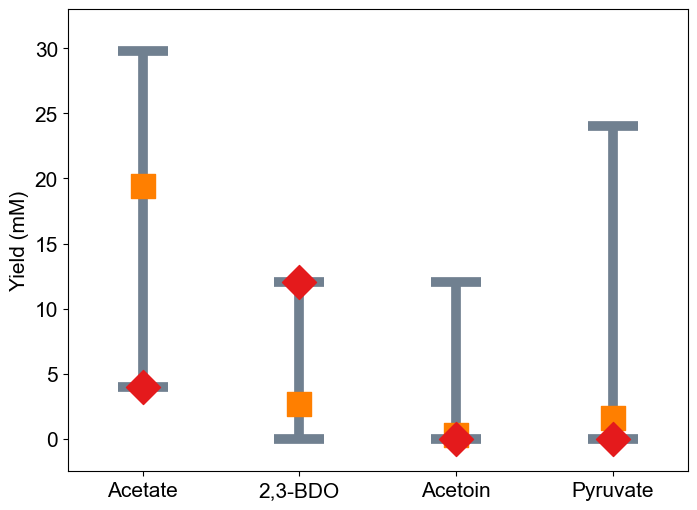

In [10]:
with plt.rc_context({"figure.figsize": (8,6),
                     "font.family": "Arial",
                     "font.size": 15,
                     "svg.fonttype": "none"}):
    cmap = plt.colormaps["Set1"]
    lw = 7 # linewidth
    ps = 300 # point size
    cs = 1300 # cap size

    # Invisible bar plot to set the bar widths...
    plt.bar(df.index, df.maximum, bottom=4*[-0.1], alpha=0, width=0.6)
    # Top and bottom of bars
    plt.scatter(df.index, df.maximum, color="slategrey", marker="_", s=cs, linewidth=lw)
    plt.scatter(df.index, df.minimum, color="slategrey", marker="_", s=cs, linewidth=lw)
    # Middle bars
    plt.vlines(df.index, df.minimum, df.maximum, color="slategrey", linewidth=lw, zorder=1)
    # Experimental points
    plt.scatter(df.index, df.Mean, marker="s", s=ps, zorder=2, color=cmap(4), label="Experimental")
    # max BDO points
    plt.scatter(opt_sol.index, opt_sol, marker="D", s=ps, zorder=4, color=cmap(0),
                label="Model Optimized")
    #plt.legend()
    plt.ylim(-2.5, 33)
    plt.ylabel("Yield (mM)")
    plt.savefig("/work/pi_yingzhang_uri_edu/jvailionis/BDO_manuscript/BDO_fig.png", dpi=600)
    #plt.savefig("/work/pi_yingzhang_uri_edu/jvailionis/BDO_manuscript/BDO_fig.svg")
    #plt.savefig("BDO_fig.tiff",
    #            dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

In [11]:
print("At least {x} mM acetate is required, representing {y}% of the carbon consumed".format(
    x=round(fvares.loc["Acetate"].minimum, 2),
    y=round(100*fvares.loc["Acetate"].minimum/(2*-m2.reactions.EX_C00031_LSQBKT_e_RSQBKT_.lower_bound))
))
print("Tg_sADH strain experimentally produced 18 mM acetate on average ({z}% of consumed carbon)".format(
    z=round(100*18/(2*-m2.reactions.EX_C00031_LSQBKT_e_RSQBKT_.lower_bound), 2)
))
print("The highest possible 2,3-BDO production in the model was {x} mM ({y}% of consumed carbon),".format(
    x=round(fvares.loc["2,3-BDO"].maximum, 2),
    y=round(100*fvares.loc["2,3-BDO"].maximum/(-m2.reactions.EX_C00031_LSQBKT_e_RSQBKT_.lower_bound))
))
print("we found an optimal redox configuration that would enable up to a {n}X increase in 2,3-BDO production".format(
    n=round(fvares.loc["2,3-BDO"].maximum/expdat.loc["2,3-BDO"].Mean, 1)
))

At least 3.95 mM acetate is required, representing 11% of the carbon consumed
Tg_sADH strain experimentally produced 18 mM acetate on average (49.18% of consumed carbon)
The highest possible 2,3-BDO production in the model was 12.02 mM (66% of consumed carbon),
we found an optimal redox configuration that would enable up to a 4.6X increase in 2,3-BDO production


#### Optimizing the redox balance for 2,3-BDO production
We simulated the redox metabolism required to generate 2,3-BDO at 40 different values between its minimum and maximum possible values. The plots show how the range of each reaction narrows as you reach higher 2,3-BDO production. The values in the yellow indicate how the metabolism must be engineered in order to maximize 2,3-BDO production.

In [12]:
points = 40
target_rxns = ["R00299", "R07159", "R01061", "BF_DASH_Nfn", "BF_DASH_H2ase", "MBH", "R01196"]
dfs = []
for x in np.linspace(*flux_variability_analysis(m2, ["TP_C03044"]).values[0], points):
    c = add_fixed_constraint(m2, "TP_C03044", x)
    df = flux_variability_analysis(m2, target_rxns)
    m2.remove_cons_vars([c])
    #df = df.reset_index().melt(id_vars=["index"], value_vars=["minimum", "maximum"])
    df = df.reset_index()
    df["BDO"] = x
    dfs.append(df)
df_comb = pd.concat(dfs)
df_comb["minProp"] = df_comb["minimum"]/df_comb.groupby("index")["maximum"].transform("max")
df_comb["maxProp"] = df_comb["maximum"]/df_comb.groupby("index")["maximum"].transform("max")
df_comb = df_comb.fillna(0)

In [13]:
a = df_comb[([x in ["R07159", "R01061"] for x in df_comb["index"]]) & \
            (df_comb["BDO"] == df_comb["BDO"].max())].set_index("index").minimum
print("Optimal GOR:GAPDH ratio = {X}:{Y}".format(X=round(a["R07159"]/a["R07159"], 1),
                                                 Y=round(a["R01061"]/a["R07159"], 1)))

Optimal GOR:GAPDH ratio = 1.0:1.5


#### Estimating Redox using under experimental conditions
Random flux simulations were calculated in the model with glucose consumption and acetate, acetoin, BDO, and pyruvate concentrations constrained based on experimental data for the Tg_sADH strain. Dots indicate the flux values for each of the highlighted reactions across all 2500 random simulations.

In [11]:
s = sample(m3, 2500, processes=4)

#### Showing response to reducing acetate
Sampling like above but forcing acetate to be at its minimum for max biomass

In [12]:
s_minAce = sample(m4, 2500, processes=4)

In [14]:
print("Median BDO:", round(s_minAce.TP_C03044.median(), 1))
print("Median acetoin:", round(s_minAce.Acetoin_DASH_t.median(), 1))

Median BDO: 2.6
Median acetoin: 3.0


**Requires matplotlib >= 3.7.0**

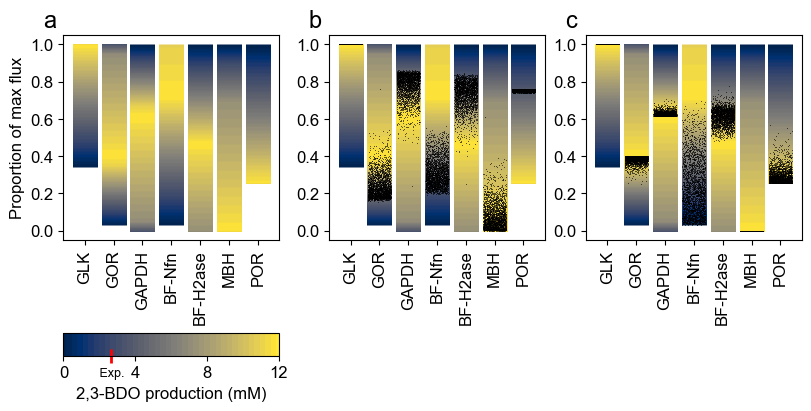

In [15]:
df_comb2 = df_comb.copy()
df_comb2.maximum = df_comb.maximum/-m2.reactions.EX_C00031_LSQBKT_e_RSQBKT_.lower_bound
df_comb2.minimum = df_comb.minimum/-m2.reactions.EX_C00031_LSQBKT_e_RSQBKT_.lower_bound
with plt.rc_context({"figure.figsize": (8, 4), "font.size": 12,
                     "axes3d.grid": False, "font.family": "Arial"}):

    fig, axes = plt.subplot_mosaic(
        """
        abc
        P..
        """,
        constrained_layout=True,
        height_ratios=[9,1])
    
    ## PARAMETERS
    #myPalette = plt.colormaps["cividis"]
    jitter=0.4
    pointsize=0.5
    lw = 18
    norm = plt.Normalize()
    margin = 0.05
    colors = plt.colormaps["cividis"](norm(df_comb.BDO))
    
    #### A, B, C, D labels
    for label, ax in axes.items():
        # label physical distance to the left and up:
        trans = mtransforms.ScaledTranslation(-15/72, 2/72, fig.dpi_scale_trans)
        if label == "P":
            pass
        else:
            ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                    fontsize="17", va="bottom", fontfamily="Arial")
    
    axes["a"].vlines(df_comb["index"], df_comb.minProp, df_comb.maxProp, linewidth=lw, color=colors, alpha=1)
    axes["a"].set_xticks(axes["a"].get_xticks())
    axes["a"].set_xticklabels(["GLK", "GOR", "GAPDH", "BF-Nfn", "BF-H2ase", "MBH", "POR"], rotation=90)
    axes["a"].set_ylabel("Proportion of max flux")
    sns.stripplot(x="variable", y="value",
                  data=s.div(s["GlcABC"], axis=0)[target_rxns].T.div(df_comb2.groupby("index").max().maximum, axis=0).T.melt(),
                  alpha=0, s=pointsize, color="black", ax=axes["a"], jitter=jitter) # invisible points to make bar spacing the same...
    axes["a"].margins(x=margin)
    axes["a"].set_xlabel(None)
    
    axes["b"].vlines(df_comb["index"], df_comb.minProp, df_comb.maxProp, linewidth=lw, color=colors, alpha=1)
    axes["b"].set_xticks(axes["a"].get_xticks())
    axes["b"].set_xticklabels(["GLK", "GOR", "GAPDH", "BF-Nfn", "BF-H2ase", "MBH", "POR"], rotation=90)
    sns.stripplot(x="variable", y="value",
                  data=s.div(s["GlcABC"], axis=0)[target_rxns].T.div(df_comb2.groupby("index").max().maximum, axis=0).T.melt(),
                  alpha=1, s=pointsize, color="black", ax=axes["b"], jitter=jitter)
    axes["b"].set_xlabel(None)
    axes["b"].set_ylabel(None)
    axes["b"].margins(x=margin)
    
    axes["c"].vlines(df_comb["index"], df_comb.minProp, df_comb.maxProp, linewidth=lw, color=colors, alpha=1)
    axes["c"].set_xticks(axes["a"].get_xticks())
    axes["c"].set_xticklabels(["GLK", "GOR", "GAPDH", "BF-Nfn", "BF-H2ase", "MBH", "POR"], rotation=90)
    sns.stripplot(x="variable", y="value",
                  data=s_minAce.div(s_minAce["GlcABC"], axis=0)[target_rxns].T.div(df_comb2.groupby("index").max().maximum, axis=0).T.melt(),
                  alpha=1, s=pointsize, color="black", ax=axes["c"], jitter=jitter)
    axes["c"].set_xlabel(None)
    axes["c"].set_ylabel(None)
    axes["c"].margins(x=margin)
    cmap = mcolors.ListedColormap(colors)
    cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=cmap), cax=axes["P"],
                        values=df_comb.BDO, orientation="horizontal", label="2,3-BDO production (mM)")
    #cbar.ax.xaxis.set_major_locator(mticker.LinearLocator(numticks=4))
    cbar.ax.xaxis.set_major_locator(mticker.MaxNLocator(4))
    cbar.ax.xaxis.set_minor_locator(mticker.FixedLocator([expdat.loc["2,3-BDO"].Mean]))
    cbar.ax.xaxis.set_minor_formatter(mticker.FixedFormatter([" Exp."]))
    cbar.ax.tick_params(which="minor", length=10, width=2, color="red", direction="inout", labelsize=9)
    #cbar.ax.xaxis.label.set_size(10)
    plt.savefig("/work/pi_yingzhang_uri_edu/jvailionis/BDO_manuscript/BDO_fig9_3panel.png", dpi=600)

In [16]:
v = df_comb2[(df_comb2.BDO == df_comb2.BDO.max()) & (df_comb2["index"] == "R01196")].maximum
a = (s.R01196/s.GlcABC).median()
print("POR flux must be reduced by {}% to reach maximum 2,3-BDO production".format(
    round(((a-v)*100/a).values[0], 2)
))
v = df_comb2[(df_comb2.BDO == df_comb2.BDO.max()) & (df_comb2["index"] == "BF_DASH_Nfn")].maximum
a = (s.BF_DASH_Nfn/s.GlcABC).median()
print("BF-Nfn flux must be increased by {}% to reach maximum 2,3-BDO production".format(
    round(((v-a)*100/a).values[0], 2)
))
print("BF-Nfn flux must be increased by {}X to reach maximum 2,3-BDO production".format(
    round((v/a).values[0], 2)
))

POR flux must be reduced by 66.02% to reach maximum 2,3-BDO production
BF-Nfn flux must be increased by 142.46% to reach maximum 2,3-BDO production
BF-Nfn flux must be increased by 2.42X to reach maximum 2,3-BDO production


#### Comparing ethanol and 2,3-BDO models
Flux sampling to investigate the effect of dMBH on ethanol and 2,3-BDO and why it differs

In [42]:
s_etoh = sample(etoh_model, 2500, processes=4)
s_etoh_dMBH = sample(etoh_model_dMBH, 2500, processes=4)
s_bdo = sample(model, 2500, processes=4)
s_bdo_dMBH = sample(model_dMBH, 2500, processes=4)

In [17]:
df_etoh = pd.DataFrame([s_etoh["ETOHt1"]/s_etoh["ACt6"],
                        s_etoh_dMBH["ETOHt1"]/s_etoh_dMBH["ACt6"]],
                       index=["$\it{adhE^{+}}$ $Δ\it{ldh}$", "$\it{adhE^{+}}$ $Δ\it{ldh}$ $Δ\it{mbh}$"]).T.melt(var_name="Strain")
df_bdo = pd.DataFrame([s_bdo["TP_C03044"]/s_bdo["ACt6"],
                        s_bdo_dMBH["TP_C03044"]/s_bdo_dMBH["ACt6"]],
                       index=["Tg_sADH", "Tg_sADH $Δ\it{mbh}$"]).T.melt(var_name="Strain")

df_etoh.replace(to_replace=0, value=0.00001, inplace=True)
df_bdo.replace(to_replace=0, value=0.00001, inplace=True)

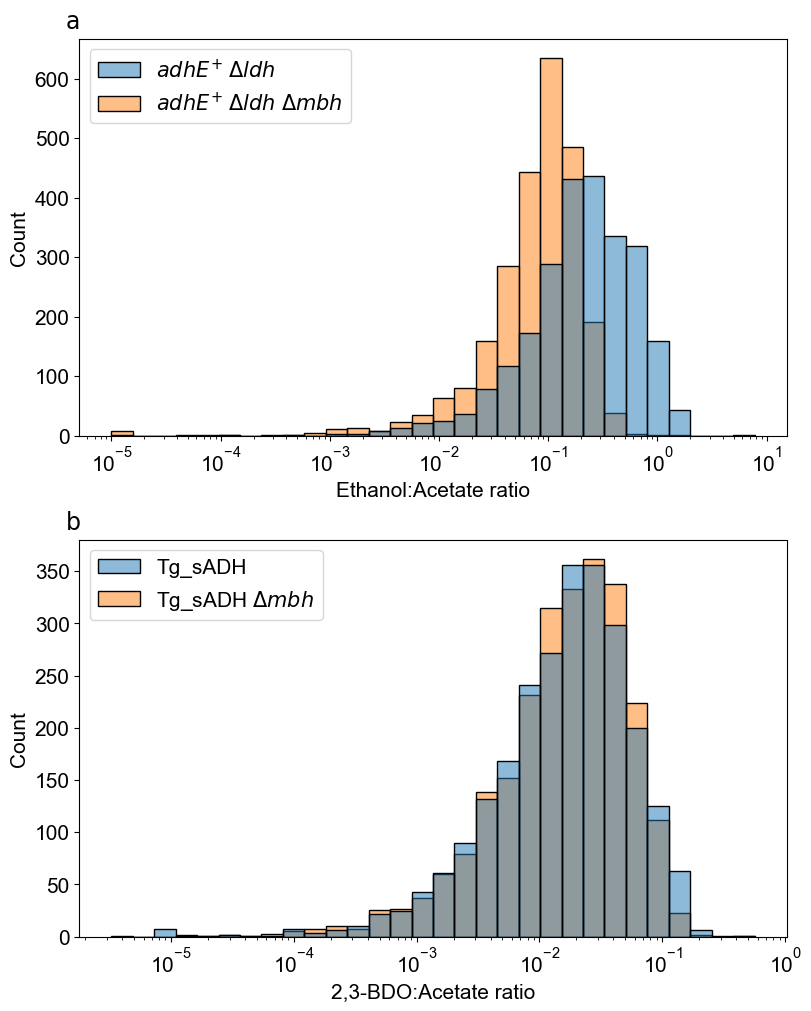

In [18]:
with plt.rc_context({"figure.figsize": (8, 10), "font.size": 15,
                     "axes3d.grid": False, "font.family": "Arial",
                     "legend.fontsize": 15}):

    fig, axes = plt.subplot_mosaic(
        """
        a
        b
        """,
        constrained_layout=True,)
    #### A, B labels
    for label, ax in axes.items():
        trans = mtransforms.ScaledTranslation(-10/72, 4/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize="17", va="bottom", fontfamily="sans")
    
    ## Panel A
    g = sns.histplot(data=df_etoh, x="value", hue="Strain", bins=30, log_scale=True, ax=axes["a"])
    g.get_legend().set_title(None)
    #axes["A"].xaxis.set_major_formatter(mticker.ScalarFormatter())
    axes["a"].set_xlabel("Ethanol:Acetate ratio")
    
    ## Panel B
    g = sns.histplot(data=df_bdo, x="value", hue="Strain", bins=30, log_scale=True, ax=axes["b"])
    g.get_legend().set_title(None)
    #axes["B"].xaxis.set_major_formatter(mticker.ScalarFormatter())
    axes["b"].set_xlabel("2,3-BDO:Acetate ratio")
    plt.savefig("/work/pi_yingzhang_uri_edu/jvailionis/BDO_manuscript/FigS5.png", dpi=600)

In [19]:
mw_etoh = mannwhitneyu(df_etoh[df_etoh["Strain"] == "$\\it{adhE^{+}}$ $Δ\\it{ldh}$"].value,
                       df_etoh[df_etoh["Strain"] == "$\\it{adhE^{+}}$ $Δ\\it{ldh}$ $Δ\\it{mbh}$"].value)
mw_bdo = mannwhitneyu(df_bdo[df_bdo["Strain"] == "Tg_sADH"].value,
                       df_bdo[df_bdo["Strain"] == "Tg_sADH $Δ\\it{mbh}$"].value)

In [20]:
print("deletion of MBH lowered the median ethanol:acetate ratio from {a} to {b}".format(
    a=round(df_etoh[df_etoh["Strain"] == "$\\it{adhE^{+}}$ $Δ\\it{ldh}$"].value.median(), 2),
    b=round(df_etoh[df_etoh["Strain"] == "$\\it{adhE^{+}}$ $Δ\\it{ldh}$ $Δ\\it{mbh}$"].value.median(), 2)
))
print("Ethanol:acetate ratio dMBH p-value:", mw_etoh.pvalue)
print()
print("the 2,3-BDO:acetate ratio changed from {c} to {d} after MBH deletion".format(
    c=round(df_bdo[df_bdo["Strain"] == "Tg_sADH"].value.median(), 4),
    d=round(df_bdo[df_bdo["Strain"] == "Tg_sADH $Δ\\it{mbh}$"].value.median(), 4)
))
print("2,3-BDO:acetate ratio dMBH p-value:", mw_bdo.pvalue)

deletion of MBH lowered the median ethanol:acetate ratio from 0.22 to 0.09
Ethanol:acetate ratio dMBH p-value: 2.5209082115050398e-222

the 2,3-BDO:acetate ratio changed from 0.0182 to 0.0182 after MBH deletion
2,3-BDO:acetate ratio dMBH p-value: 0.9737791609833899


In [54]:
with lzma.open("/work/pi_yingzhang_uri_edu/jvailionis/BDO_manuscript/pickles/samples.pkl.xz", "wb") as f:
    pickle.dump([s, s_bdo, s_bdo_dMBH, s_etoh, s_etoh_dMBH, s_minAce, test3], f)